In [1]:
%matplotlib ipympl
import json
import time
from datetime import datetime
from functools import partial

import allantools
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.signal import welch

from onix.data_tools import get_experiment_data, get_analysis_file_path
from onix.analysis.fitter import Fitter

In [14]:
def gaussian(f, f0, sigma, a, c):
    return a * np.exp(-(f-f0)**2 / (2 * sigma**2)) + c

def gaussian_fitter_histogram(xs, hists):
    xs = xs[1:] - (xs[1] - xs[0]) / 2
    nonzero_hist_mask = hists != 0
    fitter = Fitter(gaussian)
    fitter.set_nicknames({"f0": "$f_0$", "sigma": "$\\sigma$", "a": "$a$", "c": "$c$"})
    fitter.set_units({"f0": "Hz", "sigma": "Hz"})
    fitter.set_data(xs[nonzero_hist_mask], hists[nonzero_hist_mask], np.sqrt(hists[nonzero_hist_mask]))
    fitter.set_p0({"f0": np.average(xs, weights=hists), "sigma": np.std(xs), "a": np.max(hists) - np.min(hists), "c": np.min(hists)})
    return fitter

In [3]:
analysis_number = 607
file_name = "all_data.json"
file_path = get_analysis_file_path(analysis_number, file_name)
with open(file_path) as f:
    all_results = np.array(json.load(f))

In [4]:
def convert_to_timestamp(input):
    ret = datetime.strptime(input.decode("utf-8"), "%Y-%m-%d %H:%M:%S.%f+00:00").timestamp()
    return ret

unlock_data = np.loadtxt(
    "/home/icarus/Documents/data/manual/2024_07/02/unlock_counter.csv",  # the data is actually in EDT although labeled GMT
    delimiter=",",
    skiprows=1,
    converters={
        0: convert_to_timestamp,
    },
)
unlock_data_times = np.transpose(unlock_data)[0] - 3600 * 4
unlock_times = []
unlock_data_counters = np.transpose(unlock_data)[1]
for kk, value in enumerate(unlock_data_counters[1:] - unlock_data_counters[:-1]):
    if value > 0:
        unlock_times.append((unlock_data_times[kk] + unlock_data_times[kk+1]) / 2)

In [17]:
all_mask = np.ones(len(all_results), dtype=bool)
unlock_mask = np.ones(len(all_results), dtype=bool)
D_p1_mask = np.ones(len(all_results), dtype=bool)
D_m1_mask = np.ones(len(all_results), dtype=bool)
E_p1_mask = np.ones(len(all_results), dtype=bool)
E_m1_mask = np.ones(len(all_results), dtype=bool)
for kk, value in enumerate(all_results):
    for unlock_time in unlock_times:
        if value["save_epoch_times"][0] - 2 < unlock_time and unlock_time < value["save_epoch_times"][1]:
            unlock_mask[kk] = False
            break
    if value["D"]:
        D_p1_mask[kk] = True
        D_m1_mask[kk] = False
    else:
        D_p1_mask[kk] = False
        D_m1_mask[kk] = True
    if value["E"]:
        E_p1_mask[kk] = True
        E_m1_mask[kk] = False
    else:
        E_p1_mask[kk] = False
        E_m1_mask[kk] = True
        
print(f"Laser unlocked data is {(len(all_results) - len(all_results[unlock_mask])) / len(all_results) * 100:.1f}%.")

start_mask = np.ones(len(all_results), dtype=bool)
for kk in range(1000):
    start_mask[kk] = False

Laser unlocked data is 0.3%.


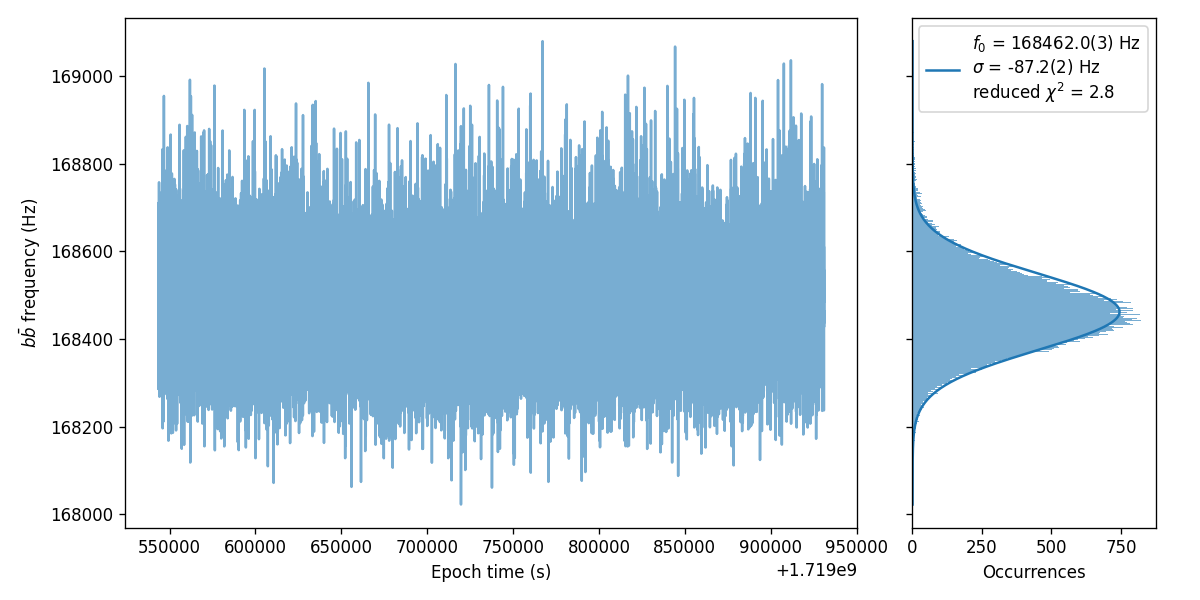

In [18]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5), dpi = 120, sharey="row", gridspec_kw={"width_ratios": [3, 1]})
n_bins = int(np.sqrt(len(all_results))) * 2
bins_alpha = 0.6

mask = unlock_mask & start_mask
fs = np.array([result["freq_offset"] for result in all_results[mask]])
ts = np.array([result["save_epoch_times"][0] for result in all_results[mask]])

axs[0].plot(ts, fs, alpha=bins_alpha)
axs[1].hist(fs, bins=n_bins, orientation="horizontal", alpha=bins_alpha)

hists, xs = np.histogram(fs, bins=n_bins)
fitter = gaussian_fitter_histogram(xs, hists)
fitter.fit()
label = fitter.result_str("f0") + "\n" + fitter.result_str("sigma") + f"\nreduced $\\chi^2$ = {fitter.reduced_chi:.1f}"
axs[1].plot(fitter.fitted_value(xs), xs, color=f"C0", label=label)
    
axs[0].set_xlabel("Epoch time (s)")
axs[0].set_ylabel("$b\\bar{b}$ frequency (Hz)")
axs[1].set_xlabel("Occurrences")
axs[1].legend()
plt.tight_layout()
plt.show()

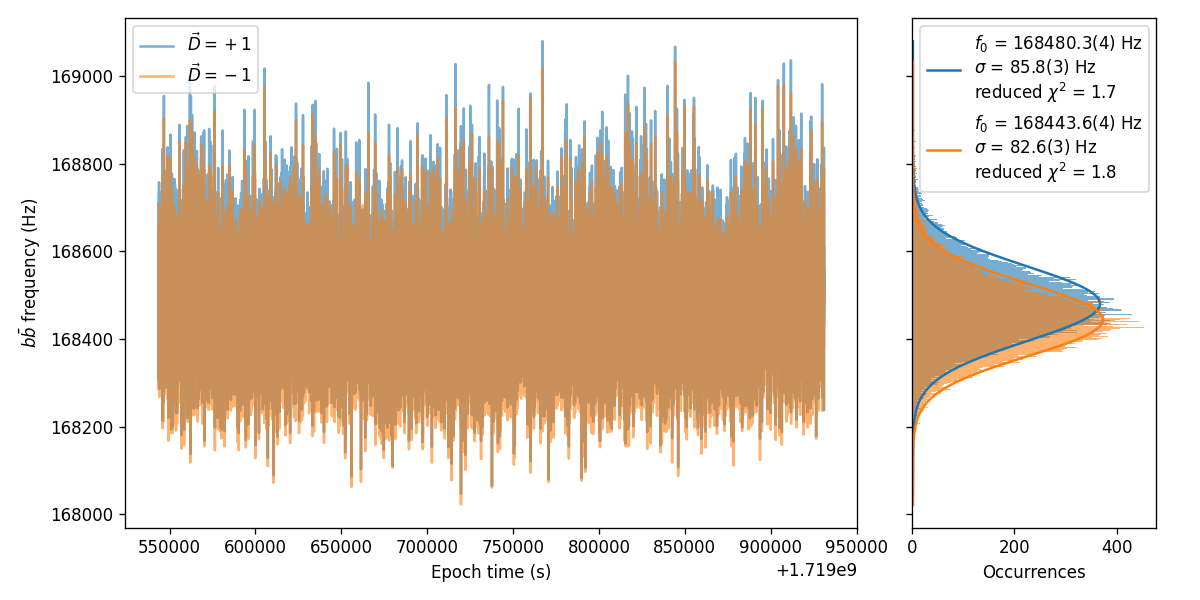

In [19]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5), dpi = 120, sharey="row", gridspec_kw={"width_ratios": [3, 1]})
n_bins = int(np.sqrt(len(all_results))) * 2
bins_alpha = 0.6

for kk, D_mask in enumerate([D_p1_mask, D_m1_mask]):
    mask = unlock_mask & start_mask & D_mask
    fs = np.array([result["freq_offset"] for result in all_results[mask]])
    ts = np.array([result["save_epoch_times"][0] for result in all_results[mask]])

    if kk == 0:
        label = "$\\vec{D} = +1$"
    else:
        label = "$\\vec{D} = -1$"
    axs[0].plot(ts, fs, label=label, alpha=bins_alpha)
    axs[1].hist(fs, bins=n_bins, orientation="horizontal", alpha=bins_alpha)
    
    hists, xs = np.histogram(fs, bins=n_bins)
    fitter = gaussian_fitter_histogram(xs, hists)
    fitter.fit()
    label = fitter.result_str("f0") + "\n" + fitter.result_str("sigma") + f"\nreduced $\\chi^2$ = {fitter.reduced_chi:.1f}"
    axs[1].plot(fitter.fitted_value(xs), xs, color=f"C{kk}", label=label)
    
axs[0].set_xlabel("Epoch time (s)")
axs[0].set_ylabel("$b\\bar{b}$ frequency (Hz)")
axs[0].legend()
axs[1].set_xlabel("Occurrences")
axs[1].legend()
plt.tight_layout()
plt.show()

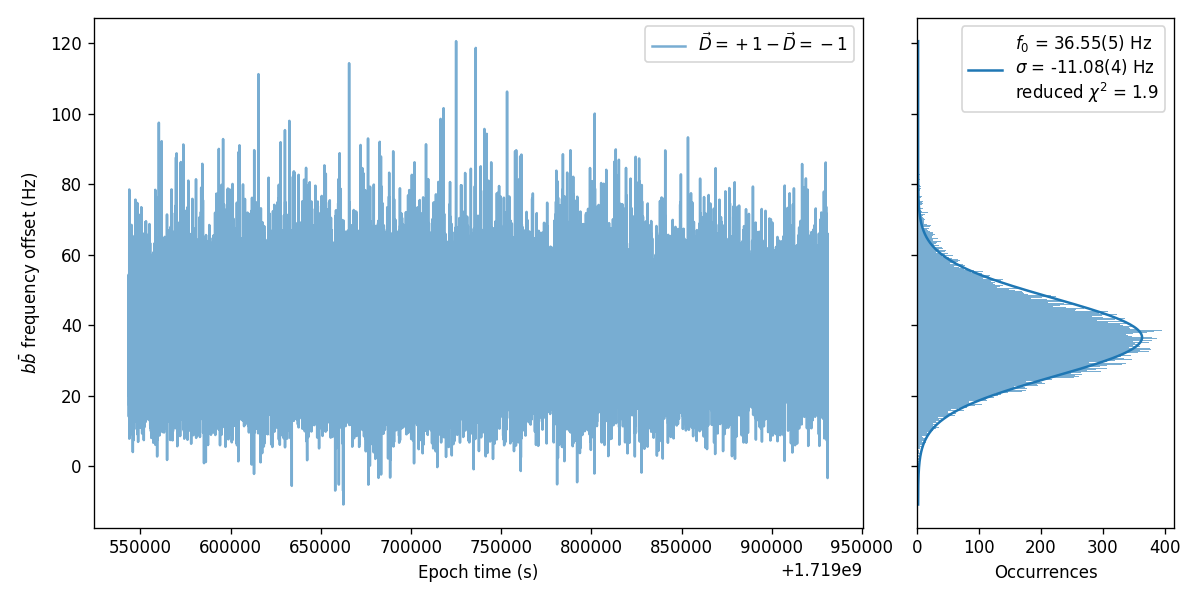

In [20]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5), dpi = 120, sharey="row", gridspec_kw={"width_ratios": [3, 1]})
n_bins = int(np.sqrt(len(all_results))) * 2
bins_alpha = 0.6

mask1 = unlock_mask & start_mask & D_p1_mask
mask2 = unlock_mask & start_mask & D_m1_mask
fs = np.array([result["freq_offset"] for result in all_results[mask1]]) - np.array([result["freq_offset"] for result in all_results[mask2]])
ts = np.array([result["save_epoch_times"][0] for result in all_results[mask1]])

label = "$\\vec{D} = +1 - \\vec{D} = -1$"
axs[0].plot(ts, fs, label=label, alpha=bins_alpha)
axs[1].hist(fs, bins=n_bins, orientation="horizontal", alpha=bins_alpha)

hists, xs = np.histogram(fs, bins=n_bins)
fitter = gaussian_fitter_histogram(xs, hists)
fitter.fit()
label = fitter.result_str("f0") + "\n" + fitter.result_str("sigma") + f"\nreduced $\\chi^2$ = {fitter.reduced_chi:.1f}"
axs[1].plot(fitter.fitted_value(xs), xs, color=f"C0", label=label)
    
axs[0].set_xlabel("Epoch time (s)")
axs[0].set_ylabel("$b\\bar{b}$ frequency offset (Hz)")
axs[0].legend()
axs[1].set_xlabel("Occurrences")
axs[1].legend()
plt.tight_layout()
plt.show()

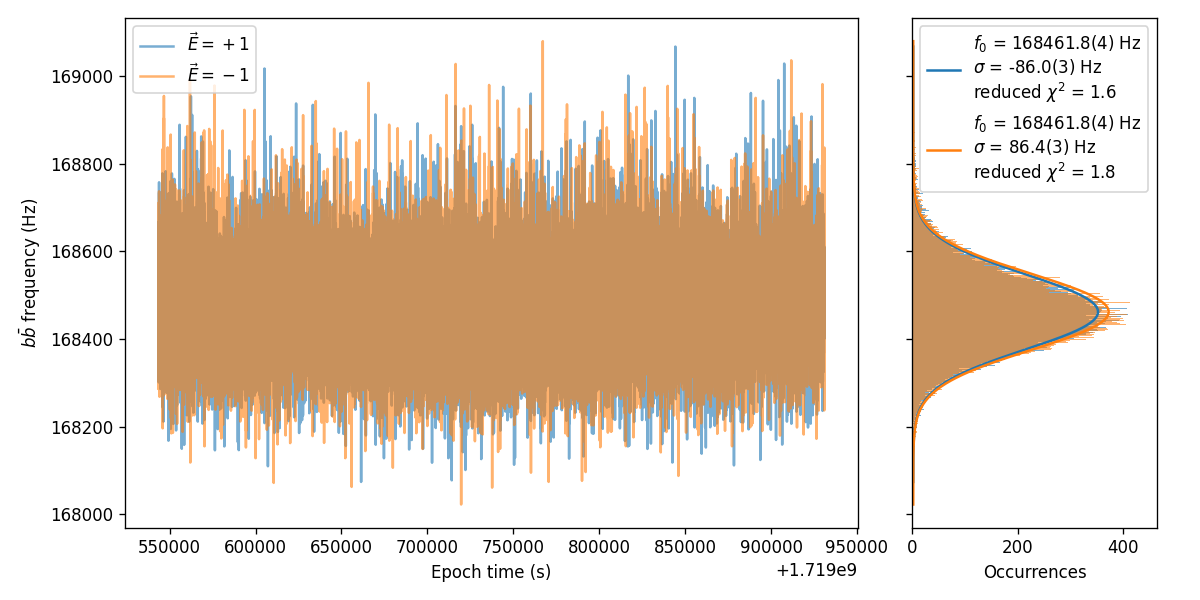

In [21]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5), dpi = 120, sharey="row", gridspec_kw={"width_ratios": [3, 1]})
n_bins = int(np.sqrt(len(all_results))) * 2
bins_alpha = 0.6

for kk, E_mask in enumerate([E_p1_mask, E_m1_mask]):
    mask = unlock_mask & start_mask & E_mask
    fs = np.array([result["freq_offset"] for result in all_results[mask]])
    ts = np.array([result["save_epoch_times"][0] for result in all_results[mask]])

    if kk == 0:
        label = "$\\vec{E} = +1$"
    else:
        label = "$\\vec{E} = -1$"
    axs[0].plot(ts, fs, label=label, alpha=bins_alpha)
    axs[1].hist(fs, bins=n_bins, orientation="horizontal", alpha=bins_alpha)
    
    hists, xs = np.histogram(fs, bins=n_bins)
    fitter = gaussian_fitter_histogram(xs, hists)
    fitter.fit()
    label = fitter.result_str("f0") + "\n" + fitter.result_str("sigma") + f"\nreduced $\\chi^2$ = {fitter.reduced_chi:.1f}"
    axs[1].plot(fitter.fitted_value(xs), xs, color=f"C{kk}", label=label)
    
axs[0].set_xlabel("Epoch time (s)")
axs[0].set_ylabel("$b\\bar{b}$ frequency (Hz)")
axs[0].legend()
axs[1].set_xlabel("Occurrences")
axs[1].legend()
plt.tight_layout()
plt.show()

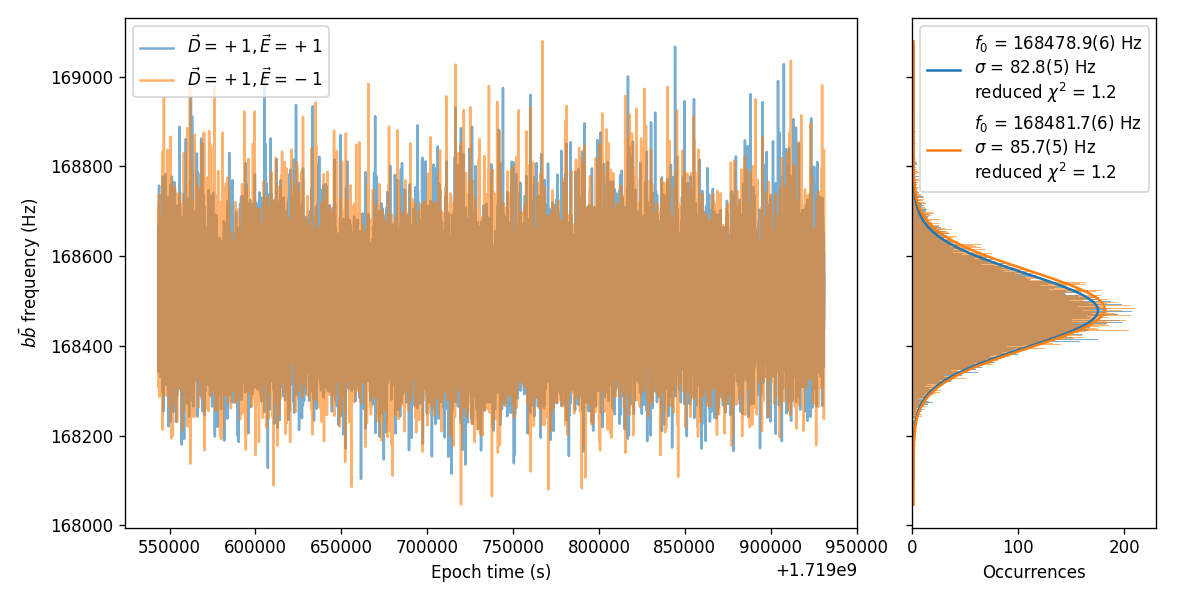

In [25]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5), dpi = 120, sharey="row", gridspec_kw={"width_ratios": [3, 1]})
n_bins = int(np.sqrt(len(all_results))) * 2
bins_alpha = 0.6

for kk, E_mask in enumerate([E_p1_mask, E_m1_mask]):
    mask = unlock_mask & start_mask * D_p1_mask & E_mask
    fs = np.array([result["freq_offset"] for result in all_results[mask]])
    ts = np.array([result["save_epoch_times"][0] for result in all_results[mask]])

    if kk == 0:
        label = "$\\vec{D} = +1, \\vec{E} = +1$"
    else:
        label = "$\\vec{D} = +1, \\vec{E} = -1$"
    axs[0].plot(ts, fs, label=label, alpha=bins_alpha)
    axs[1].hist(fs, bins=n_bins, orientation="horizontal", alpha=bins_alpha)
    
    hists, xs = np.histogram(fs, bins=n_bins)
    fitter = gaussian_fitter_histogram(xs, hists)
    fitter.fit()
    label = fitter.result_str("f0") + "\n" + fitter.result_str("sigma") + f"\nreduced $\\chi^2$ = {fitter.reduced_chi:.1f}"
    axs[1].plot(fitter.fitted_value(xs), xs, color=f"C{kk}", label=label)
    
axs[0].set_xlabel("Epoch time (s)")
axs[0].set_ylabel("$b\\bar{b}$ frequency (Hz)")
axs[0].legend()
axs[1].set_xlabel("Occurrences")
axs[1].legend()
plt.tight_layout()
plt.show()

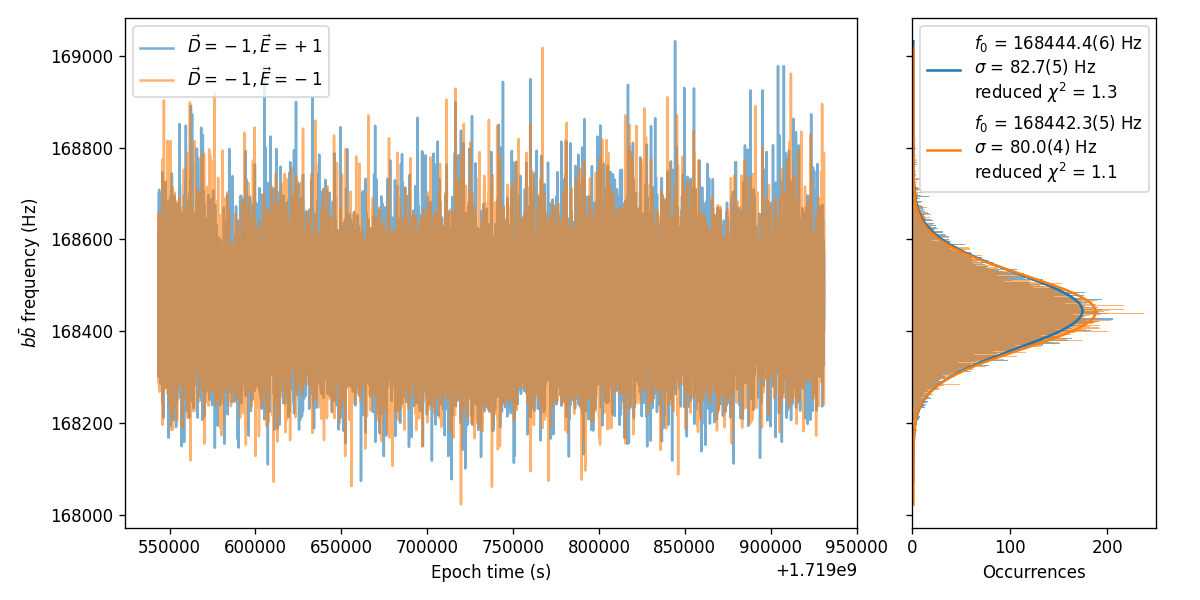

In [26]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5), dpi = 120, sharey="row", gridspec_kw={"width_ratios": [3, 1]})
n_bins = int(np.sqrt(len(all_results))) * 2
bins_alpha = 0.6

for kk, E_mask in enumerate([E_p1_mask, E_m1_mask]):
    mask = unlock_mask & start_mask * D_m1_mask & E_mask
    fs = np.array([result["freq_offset"] for result in all_results[mask]])
    ts = np.array([result["save_epoch_times"][0] for result in all_results[mask]])

    if kk == 0:
        label = "$\\vec{D} = -1, \\vec{E} = +1$"
    else:
        label = "$\\vec{D} = -1, \\vec{E} = -1$"
    axs[0].plot(ts, fs, label=label, alpha=bins_alpha)
    axs[1].hist(fs, bins=n_bins, orientation="horizontal", alpha=bins_alpha)
    
    hists, xs = np.histogram(fs, bins=n_bins)
    fitter = gaussian_fitter_histogram(xs, hists)
    fitter.fit()
    label = fitter.result_str("f0") + "\n" + fitter.result_str("sigma") + f"\nreduced $\\chi^2$ = {fitter.reduced_chi:.1f}"
    axs[1].plot(fitter.fitted_value(xs), xs, color=f"C{kk}", label=label)
    
axs[0].set_xlabel("Epoch time (s)")
axs[0].set_ylabel("$b\\bar{b}$ frequency (Hz)")
axs[0].legend()
axs[1].set_xlabel("Occurrences")
axs[1].legend()
plt.tight_layout()
plt.show()

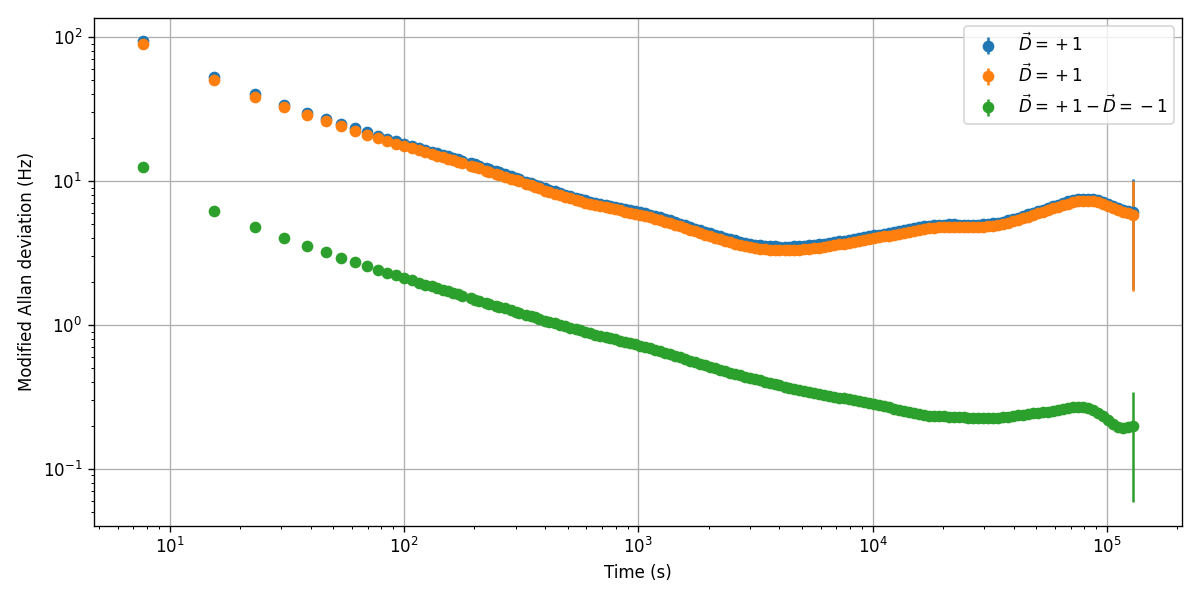

In [22]:
mask1 = unlock_mask & start_mask & D_p1_mask
mask2 = unlock_mask & start_mask & D_m1_mask

fs1 = np.array([result["freq_offset"] for result in all_results[mask1]])
taus1 = np.logspace(0, np.log10(len(fs1) // 3), 200)
real_taus1, allan1, allan_err1, _ = allantools.mdev(fs1, data_type="freq", taus=taus1)
real_taus1 *= all_results[mask1][1]["save_epoch_times"][0] - all_results[mask1][0]["save_epoch_times"][0]

fs2 = np.array([result["freq_offset"] for result in all_results[mask2]])
taus2 = np.logspace(0, np.log10(len(fs2) // 3), 200)
real_taus2, allan2, allan_err2, _ = allantools.mdev(fs2, data_type="freq", taus=taus2)
real_taus2 *= all_results[mask2][1]["save_epoch_times"][0] - all_results[mask2][0]["save_epoch_times"][0]

fs3 = fs2 - fs1
taus3 = np.logspace(0, np.log10(len(fs3) // 3), 200)
real_taus3, allan3, allan_err3, _ = allantools.mdev(fs3, data_type="freq", taus=taus3)
real_taus3 *= all_results[mask1][1]["save_epoch_times"][0] - all_results[mask1][0]["save_epoch_times"][0]

fig, ax = plt.subplots(figsize = (10, 5), dpi = 120)
ax.errorbar(real_taus1, allan1, allan_err1, fmt="o", label="$\\vec{D}=+1$")
ax.errorbar(real_taus2, allan2, allan_err2, fmt="o", label="$\\vec{D}=+1$")
ax.errorbar(real_taus3, allan3, allan_err3, fmt="o", label="$\\vec{D}=+1 - \\vec{D}=-1$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Modified Allan deviation (Hz)")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

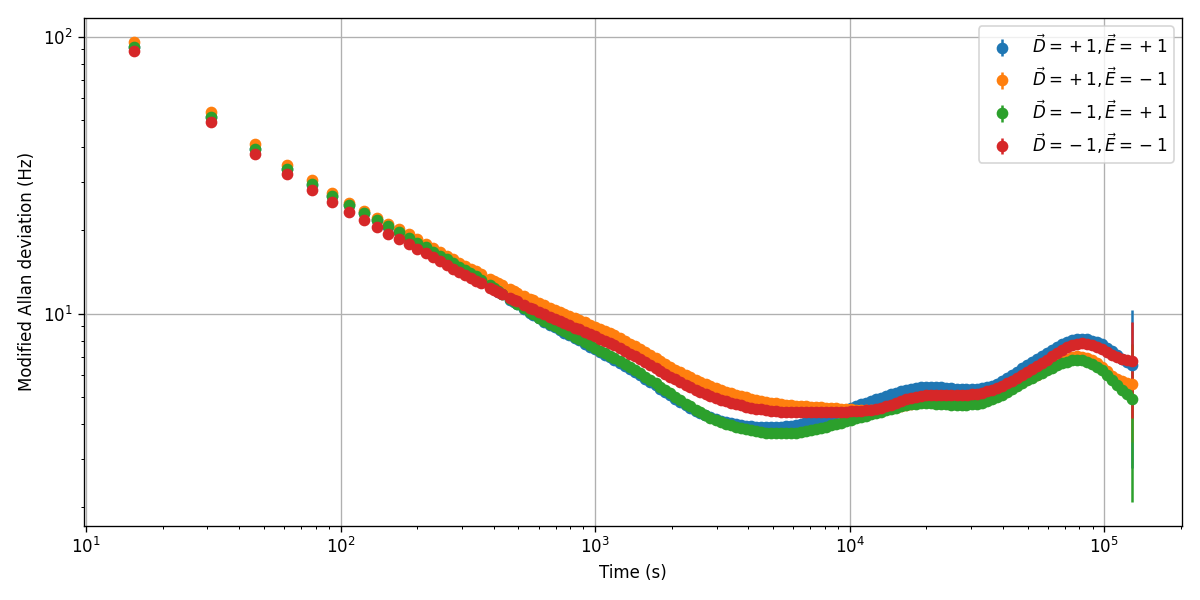

In [27]:
fig, ax = plt.subplots(figsize = (10, 5), dpi = 120)

for kk, D_mask in enumerate([D_p1_mask, D_m1_mask]):
    for ll, E_mask in enumerate([E_p1_mask, E_m1_mask]):
        mask = unlock_mask & start_mask & D_mask & E_mask
        fs = np.array([result["freq_offset"] for result in all_results[mask]])
        taus = np.logspace(0, np.log10(len(fs) // 3), 200)
        real_taus, allan, allan_err, _ = allantools.mdev(fs, data_type="freq", taus=taus)
        real_taus *= all_results[mask][1]["save_epoch_times"][0] - all_results[mask][0]["save_epoch_times"][0]
        if kk == 0:
            label = "$\\vec{D} = +1, "
        else:
            label = "$\\vec{D} = -1, "
        if ll == 0:
            label += "\\vec{E} = +1$"
        else:
            label += "\\vec{E} = -1$"
        ax.errorbar(real_taus, allan, allan_err, fmt="o", label=label)
        
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Modified Allan deviation (Hz)")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

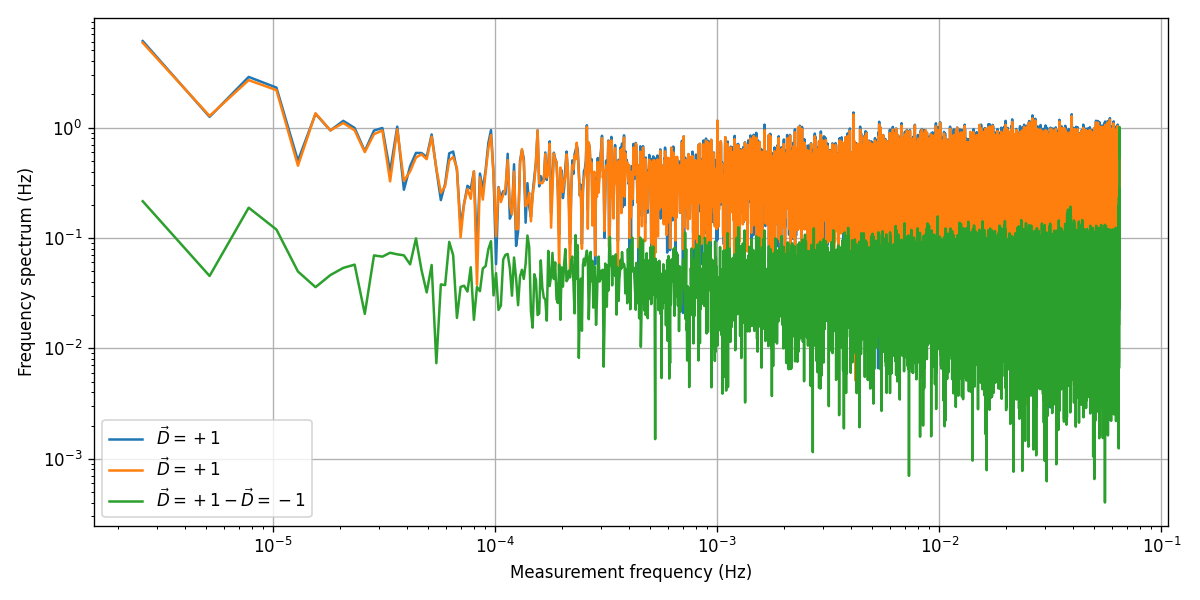

In [23]:
mask1 = unlock_mask & start_mask & D_p1_mask
mask2 = unlock_mask & start_mask & D_m1_mask

fs1 = np.array([result["freq_offset"] for result in all_results[mask1]])
fft_freqs1 = np.fft.rfftfreq(len(fs1), all_results[mask1][1]["save_epoch_times"][0] - all_results[mask1][0]["save_epoch_times"][0])
fft1 = np.abs(np.fft.rfft(fs1)) / len(fs1)

fs2 = np.array([result["freq_offset"] for result in all_results[mask2]])
fft_freqs2 = np.fft.rfftfreq(len(fs2), all_results[mask2][1]["save_epoch_times"][0] - all_results[mask2][0]["save_epoch_times"][0])
fft2 = np.abs(np.fft.rfft(fs2)) / len(fs2)

fs3 = fs2 - fs1
fft_freqs3 = np.fft.rfftfreq(len(fs3), all_results[mask1][1]["save_epoch_times"][0] - all_results[mask1][0]["save_epoch_times"][0])
fft3 = np.abs(np.fft.rfft(fs3)) / len(fs3)

fig, ax = plt.subplots(figsize = (10, 5), dpi = 120)
ax.plot(fft_freqs1[1:], fft1[1:], label="$\\vec{D}=+1$")
ax.plot(fft_freqs2[1:], fft2[1:], label="$\\vec{D}=+1$")
ax.plot(fft_freqs3[1:], fft3[1:], label="$\\vec{D}=+1 - \\vec{D}=-1$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Measurement frequency (Hz)")
ax.set_ylabel("Frequency spectrum (Hz)")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()

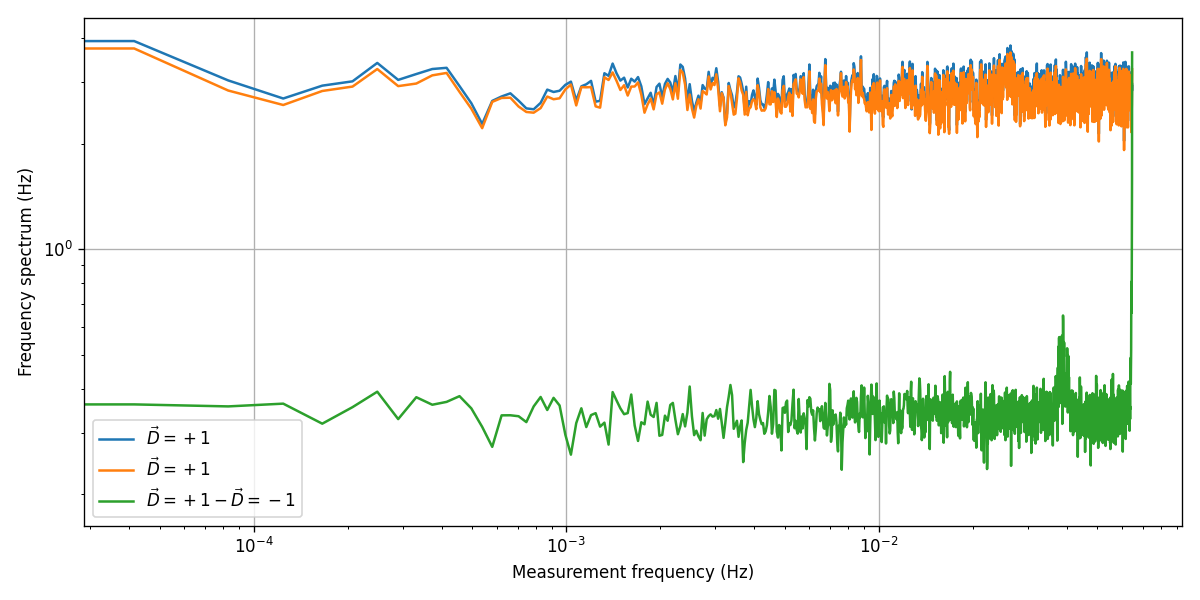

In [31]:
mask1 = unlock_mask & start_mask & D_p1_mask
mask2 = unlock_mask & start_mask & D_m1_mask
num_of_segments = 16

fs1 = np.array([result["freq_offset"] for result in all_results[mask1]])
t_step1 = all_results[mask1][1]["save_epoch_times"][0]-all_results[mask1][0]["save_epoch_times"][0]
welch_freqs1, welch1 = welch(fs1, fs=1/t_step1, nperseg=len(fs1)//num_of_segments, scaling="spectrum")
welch1 = np.sqrt(welch1)

fs2 = np.array([result["freq_offset"] for result in all_results[mask2]])
t_step2 = all_results[mask2][1]["save_epoch_times"][0]-all_results[mask2][0]["save_epoch_times"][0]
welch_freqs2, welch2 = welch(fs2, fs=1/t_step2, nperseg=len(fs2)//num_of_segments, scaling="spectrum")
welch2 = np.sqrt(welch2)

fs3 = fs2 - fs1
welch_freqs3, welch3 = welch(fs3, fs=1/t_step1, nperseg=len(fs3)//num_of_segments, scaling="spectrum")
welch3 = np.sqrt(welch3)

fig, ax = plt.subplots(figsize = (10, 5), dpi = 120)
ax.plot(welch_freqs1, welch1, label="$\\vec{D}=+1$")
ax.plot(welch_freqs2, welch2, label="$\\vec{D}=+1$")
ax.plot(welch_freqs3, welch3, label="$\\vec{D}=+1 - \\vec{D}=-1$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Measurement frequency (Hz)")
ax.set_ylabel("Frequency spectrum (Hz)")
ax.legend()
ax.grid()
plt.tight_layout()
plt.show()